In [3]:
# -*- coding : utf-8 -*-

## KALMAN FILTER

### IMPORTATION
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import math as mt
import sys

### KALMAN FILTER #################################################################################

def Kalman_filter(mu,flow,\
    L,NX,T,NT,std_dev,state_diam):
    """ Comnpute NT steps of Kalman filter 
    to reconstruct the initial condition :
    obs        -- real measurement (eventually noisy) (nobs x NT)
    flow       -- evolution matrix (dynamic) (NXxNX)
    f_cste     -- cste part of the dynamic (NX)
    op_obs     -- operator of observation C at time t (nobs x NX)
               -- parameters of the model :
    Y = [0,L] meshed with NX points
     Z = [0,T] meshed with NT points
    std_dev    -- standart deviation
    state_diam -- a priori on the initial condition
    """
    ### INITIALISATION
    # Construction of the observer (equal zero for the initial condition taken as parameter)
    # First moment
    operator_moment_1= L/NX*np.linspace(L/NX, L, NX)
    # Second moment
    operator_moment_2= L/NX*np.square(np.linspace(L/NX, L, NX))
    observer_kalman = np.vstack((operator_moment_1, np.zeros(NX), \
    operator_moment_2, np.zeros(NX)))\
    .reshape(2,2*(NX))

    # Construction of the new dynamic (identity for the initial condition)
    flow_kalman = np.concatenate((\
    np.concatenate((flow,np.zeros((NX,NX))),axis=1),\
    np.concatenate((np.zeros((NX,NX)),np.eye(NX)),axis=1)))

    # Construction of the norm of the two spaces
    # norm_observation = (T/NT)*(1/standart_deviation)**2*np.eye(2)
    inv_norm_observation = (NT/T)*(std_dev)**2*np.eye(2)


    # Initialisation of the covariance matrix
    covariance_operator_m = np.kron(np.ones((2,2)),np.eye(NX))
    covariance_operator_p = covariance_operator_m.copy()

    # Initialisation of the state
    state_m = np.kron(np.ones(2),state_diam)
    state_p = state_m.copy()
    state_kalman = np.zeros((2*NX,NT))

    ### KALMAN FILTER
    for k in range(0,NT):
        # Saving the solution
        state_kalman[:,k] = state_m.copy()

        ### CORRECTION
        # Covariance computation +
        interim_matrix = inv_norm_observation + observer_kalman.dot(covariance_operator_m).dot(observer_kalman.transpose())
        kalman_gain = covariance_operator_m.dot(observer_kalman.transpose()).dot(np.linalg.inv(interim_matrix))

        covariance_operator_p = (np.eye(2*NX) - kalman_gain.dot(observer_kalman)).dot(covariance_operator_m)\
        .dot(np.transpose((np.eye(2*NX) - kalman_gain.dot(observer_kalman)))) \
        + kalman_gain.dot(inv_norm_observation).dot(np.transpose(kalman_gain))

        # State correction computation +
        state_p = state_m + kalman_gain\
        .dot(mu[:,k]- np.dot(observer_kalman,state_m))

        ### PREDICTION
        # Covariance computation -
        covariance_operator_m = flow_kalman.dot(covariance_operator_p).dot(flow_kalman.transpose())

        # State prediction computation -
        state_m = np.dot(flow_kalman,state_p)

    return state_kalman[NX:,:]

[[0. 1. 0. ... 0. 0. 0.]
 [0. 0. 1. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 1. 0.]
 [0. 0. 0. ... 0. 0. 1.]
 [0. 0. 0. ... 0. 0. 0.]]
0.0
0.0


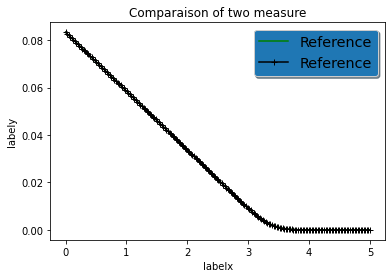

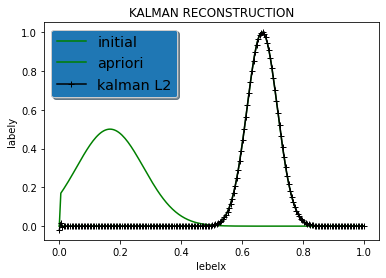

In [6]:
### PHYSICAL PARAMETERS
b = 0.2  # Depolymerisation speed
L = 1.0  # Domain size
T = 5.0  # Integration time

### NUMERICAL PARAMETERS
NX = 200 # Initial number of grid points
NT = mt.ceil(b*T*NX/L) # Number of time steps



### INITIAL CONDITION
x = np.linspace(0.0,L,NX)
cmax = 1.0 # Maximum concentration of polymers
imax = 2*L/3
sigma = L/20
def Gaussienne(NX,L,c0,i0,s0):
    x = np.linspace(0.0,L,NX)
    gaussienne = c0*np.exp(-(x-i0)**2/(2*s0**2)) # Gaussienne
    gaussienne[0]=0
    return gaussienne


### VECTOR INITIALISATION
# Initial condition set as a gaussian
state_init = Gaussienne(NX,L,cmax,imax,sigma)
# plt.plot(x,state_init)

### RESOLUTION OF THE DIRECT PROBLEM
flow = np.eye(NX)+b*T/NT*NX/L*(np.diag(np.ones(NX-1),1)-np.eye(NX))
print(flow)
# Initialisation de l'état
state = np.zeros((NX,NT))
state[:,0] = state_init.copy()

## MOMENT 
# DANS L'ESPACE DES SOLUTIONS
obs1 = L/NX*np.linspace(L/NX,L,NX)
obs2 = L/NX*np.square(np.linspace(L/NX,L,NX))
op_obs = np.vstack((obs1,obs2))
mu1 = np.zeros(NT)
mu1[0] = obs1.dot(state[:,0])
mu2 = np.zeros(NT)
mu2[0] = obs2.dot(state[:,0])

## Resolution of the direct problem
for n in range(0,NT-1):
    state[:,n+1] = flow.dot(state[:,n])
    mu1[n+1] = obs1.dot(state[:,n+1])
    mu2[n+1] = obs2.dot(state[:,n+1])
mu = np.vstack((mu1,mu2))

# # ### MEASURE COMPARAISON
# 

### NOISE
epsilon = 0.0
mu1_e = mu1+np.amax(mu1)*epsilon*(np.random.rand(NT)-0.5*np.ones(NT))
mu2_e = mu2+np.amax(mu2)*epsilon*(np.random.rand(NT)-0.5*np.ones(NT))
noise = np.linalg.norm(mu1_e-mu1,2)/np.linalg.norm(mu1)
print(epsilon)
print(noise)
mu_e = np.vstack((mu1_e,mu2_e))
# plot
fig, ax = plt.subplots()
ax.plot(np.linspace(0,T,NT), mu1, 'g-', label="Reference")
ax.plot(np.linspace(0,T,NT), mu1_e, 'k+-', label="Reference")
legend = ax.legend(loc='upper right', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C0')
ax.set(xlabel='labelx', ylabel='labely',
       title='Comparaison of two measure')

## Resolution of the inverse problem
state_apriori = Gaussienne(NX,L,0.5*cmax,imax-L/2,2.2*sigma)
state_kl1 = Kalman_filter(mu_e,flow,L,NX,T,NT,0.000001,state_apriori)
state_kl2 = state_kl1[:,NT-1]

fig, ax = plt.subplots()
ax.plot(x, state_init, 'g-', label= "initial")
ax.plot(x, state_apriori, 'g-', label= "apriori")
ax.plot(x, state_kl2, 'k+-', label="kalman L2")
legend = ax.legend(loc='upper left', shadow=True, fontsize='x-large')
legend.get_frame().set_facecolor('C0')
ax.set(xlabel='lebelx', ylabel='labely',
       title='KALMAN RECONSTRUCTION')

plt.show()
